In [664]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [665]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [666]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tagsDf.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [667]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [668]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.head(2)

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
0,241946101,241946099,2017-06-12 09:21:03+00:00,2017-06-12 09:13:51.063000+00:00,2017-06-12 09:21:43+00:00,25614.1,canceled,2018-06-02 14:51:19.734000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
1,241946103,241946099,2017-06-12 09:22:43+00:00,2017-06-12 09:13:51.107000+00:00,2017-06-12 09:21:43+00:00,25614.2,canceled,2018-06-02 14:51:19.764000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...


### Import tag comparison pairs

In [669]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[2:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
2,5.1.1,5.1.2
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3


## Import release commits

In [670]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Import tags difference commits (git log tag1...tag2) (1)

In [671]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits.tail(2)

,from_tag,to_tag,ahead_sha
15603,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df
15604,8.4.1.35646,8.4.2.36762,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6


In [672]:
tags_comparison_commits  = replace_tags_with_jira(tags_comparison_commits)
tags_comparison_commits.rename(columns={"ahead_sha": "commitsha"}, inplace=True)
tags_comparison_commits.tail(2)

,commitsha,to_tag,from_tag
15603,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1
15604,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6,8.4.2,8.4.1


In [673]:
tags_comparison_commits.shape

(15605, 3)

### Import tags commits (1) + iterative PRs

In [674]:
tags_iterative_pr_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_pairs_iterative_commits.csv", index_col=0)
tags_iterative_pr_commits.tail(2)

,from_tag,to_tag,commitsha
122451,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
122452,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [675]:
tags_iterative_pr_commits  = replace_tags_with_jira(tags_iterative_pr_commits)
tags_iterative_pr_commits.tail(2)

,commitsha,to_tag,from_tag
122451,ed1a72601c559e86ccd96004c99157421b6bcb20,8.4.2,8.4.1
122452,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1


In [676]:
tags_iterative_pr_commits.shape

(122453, 3)

### Import tags commits the ones nor in (1) or (2) assigned using Jira FixVersion for the issue in commitmessage

In [677]:
tags_fix_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_fix_commits.csv", index_col=0)
tags_fix_commits.tail(2)

,from_tag,to_tag,commitsha
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40
3246,8.4.1,8.4.2,df64c184d1427f74592459b42093e8b0b6878c98


In [678]:
tags_fix_commits.shape

(3247, 3)

# Start

In [679]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

def get_builds_from_ids(_builds, _build_ids):
    return _builds[(_builds.id.isin(_build_ids))]

def get_commits_from_comparison_row(row, commitsDf):
    _x = commitsDf
    return _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha

### Builds metrics

**Number of jobs per build**

In [680]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_n_job_per_build(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("buildid").id.count().mean()

def calculate_average_n_job_per_build_pr(row):
    return calculate_average_n_job_per_build(row, tags_iterative_pr_commits)
def calculate_average_n_job_per_build_direct(row):
    return calculate_average_n_job_per_build(row, tags_comparison_commits)
def calculate_average_n_job_per_build_fix(row):
    return calculate_average_n_job_per_build(row, tags_fix_commits)
def calculate_average_n_job_per_build_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_n_job_per_build(row, _tmp)

In [681]:
tags_comparison["average_n_job_per_build"] = tags_comparison.apply(calculate_average_n_job_per_build_pr_and_fix, axis=1)

<AxesSubplot:>

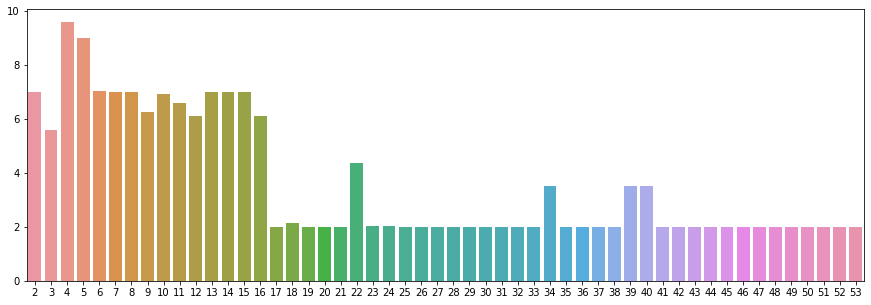

In [682]:
sns.barplot(x=tags_comparison["average_n_job_per_build"].index, \
            y=tags_comparison["average_n_job_per_build"].values)

**Number of builds per pull request**

In [683]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_pr_builds(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

def calculate_percentage_pr_builds_pr(row):
    return calculate_percentage_pr_builds(row, tags_iterative_pr_commits)
def calculate_percentage_pr_builds_direct(row):
    return calculate_percentage_pr_builds(row, tags_comparison_commits)
def calculate_percentage_pr_builds_fix(row):
    return calculate_percentage_pr_builds(row, tags_fix_commits)
def calculate_percentage_pr_builds_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_pr_builds(row, _tmp)

In [684]:
tags_comparison["percentage_pr_builds"] = tags_comparison.apply(calculate_percentage_pr_builds_pr_and_fix, axis=1)

<AxesSubplot:>

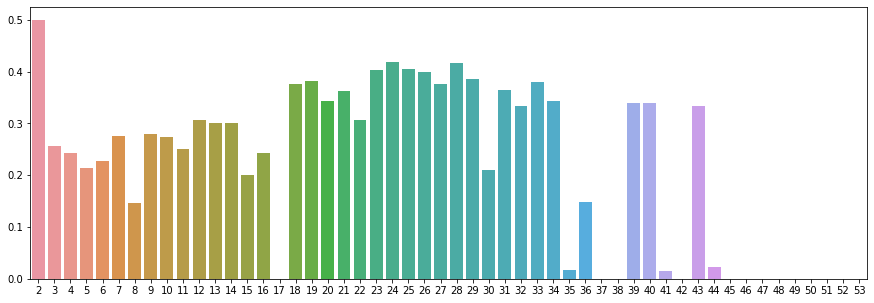

In [685]:
sns.barplot(x=tags_comparison["percentage_pr_builds"].index, \
            y=tags_comparison["percentage_pr_builds"].values)

In [686]:
tags_comparison[tags_comparison.percentage_pr_builds == 0.4]

,from_author_date,to_author_date,ahead_by,behind_by,from_sha,to_sha,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days,to_tag,from_tag,average_n_job_per_build,percentage_pr_builds
26,2017-11-07 15:03:37,2017-12-20 16:32:02,25,0,5d031d9d2ac3f69b4b9bc600d50563b1886c7d8b,426519346f51f7b980a76f9050f983110550509d,25,43 days 01:28:25,43.0614,2017-11-07 16:03:37,2017-12-20 17:32:02,43 days 01:28:25,43.0614,6.7.1,6.7,2.0,0.4


In [687]:
tags_comparison[tags_comparison.percentage_pr_builds == 0][["from_tag", "to_tag"]]

,from_tag,to_tag
17,6.1,6.1.1
37,7.3,7.4
38,7.4,7.5
42,7.8,7.9
45,7.9.1,7.9.3
46,7.9.3,7.9.4
47,8.0,8.1
48,8.1,8.2
49,8.2,8.3
50,8.3,8.3.1


* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Average build duration**

In [688]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_build_duration(row, commitsDf, state=None):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    if(not state):
        return _all_builds.duration.mean()
    return _all_builds[_all_builds.state==state].duration.mean()

def calculate_average_build_duration_pr(row):
    return calculate_average_build_duration(row, tags_iterative_pr_commits)
def calculate_average_build_duration_direct(row):
    return calculate_average_build_duration(row, tags_comparison_commits)
def calculate_average_build_duration_fix(row):
    return calculate_average_build_duration(row, tags_fix_commits)
def calculate_average_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp)
def calculate_average_passed_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp, "passed")

In [689]:
tags_comparison["average_build_duration"] = tags_comparison.apply(calculate_average_build_duration_pr_and_fix, axis=1)

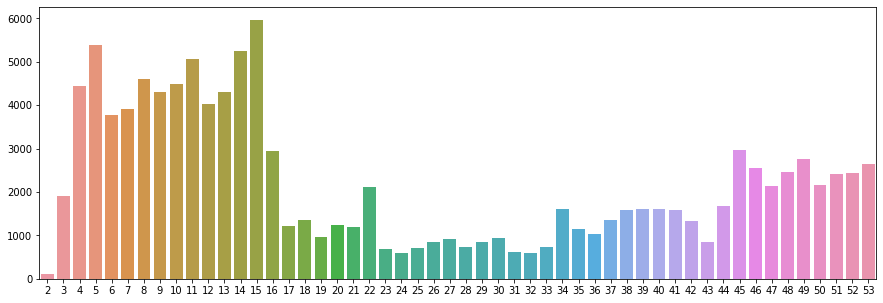

In [690]:
sns.barplot(x=tags_comparison["average_build_duration"].index, \
            y=tags_comparison["average_build_duration"].values)
plt.show()

In [691]:
tags_comparison["average_passed_build_duration"] = tags_comparison.apply(calculate_average_passed_build_duration_pr_and_fix, axis=1)

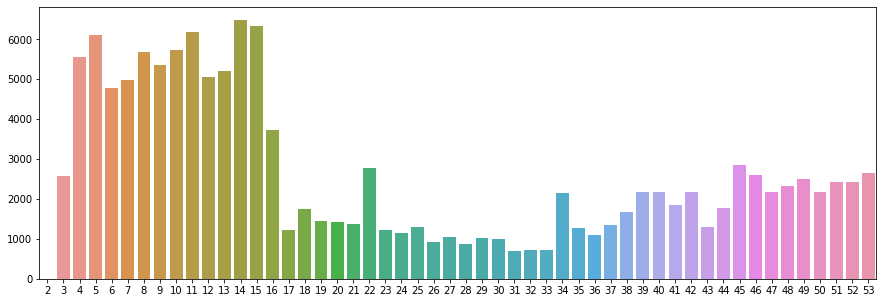

In [692]:
sns.barplot(x=tags_comparison["average_passed_build_duration"].index, \
            y=tags_comparison["average_passed_build_duration"].values)
plt.show()

### Jobs metrics

**Average job duration**

In [693]:
jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

In [694]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

In [695]:
tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

In [696]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

In [697]:
tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

<AxesSubplot:>

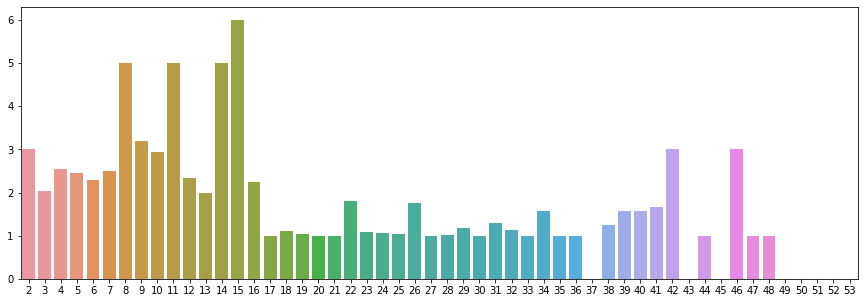

In [698]:
sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs per pull request**

In [699]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_pull_request(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.commitref.str.contains("refs/pull/")]
    return _jobs.groupby("commitref").id.count().median()
    
def calculate_median_n_job_per_pull_request_per_commit_pr(row):
    return calculate_median_n_job_per_pull_request(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_pull_request_per_commit_direct(row):
    return calculate_median_n_job_per_pull_request(row, tags_comparison_commits)
def calculate_median_n_job_per_pull_request_per_commit_fix(row):
    return calculate_median_n_job_per_pull_request(row, tags_fix_commits)
def calculate_median_n_job_per_pull_request_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_pull_request(row, _tmp)

In [700]:
tags_comparison["median_n_job_per_pull_request"] =\
tags_comparison.apply(calculate_median_n_job_per_pull_request_commit_pr_and_fix, axis=1)

<AxesSubplot:>

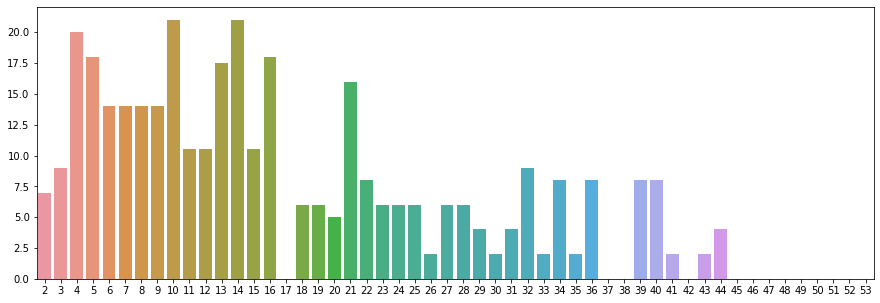

In [701]:
sns.barplot(x=tags_comparison["median_n_job_per_pull_request"].index, \
            y=tags_comparison["median_n_job_per_pull_request"].values)

**Median number of jobs per commitmessage (if starting with SONAR-)**

In [702]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_commitmessage(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("commitmessage").id.count().median()
    
def calculate_median_n_job_per_commitmessage_per_commit_pr(row):
    return calculate_median_n_job_per_commitmessage(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_commitmessage_per_commit_direct(row):
    return calculate_median_n_job_per_commitmessage(row, tags_comparison_commits)
def calculate_median_n_job_per_commitmessage_per_commit_fix(row):
    return calculate_median_n_job_per_commitmessage(row, tags_fix_commits)
def calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_commitmessage(row, _tmp)

In [703]:
tags_comparison["median_n_job_per_commitmessage"] =\
tags_comparison.apply(calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix, axis=1)

<AxesSubplot:>

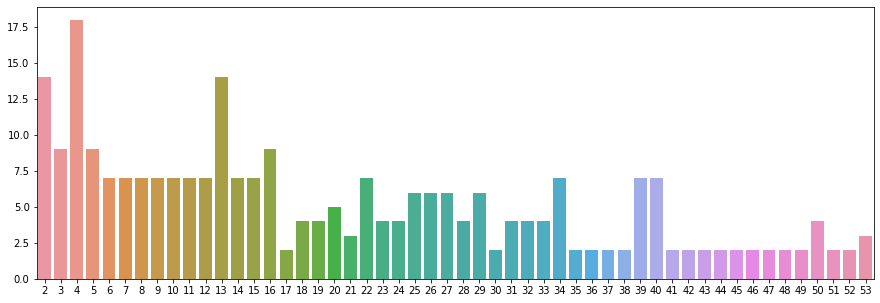

In [704]:
sns.barplot(x=tags_comparison["median_n_job_per_commitmessage"].index, \
            y=tags_comparison["median_n_job_per_commitmessage"].values)

**Number of jobs canceled or errored**

In [705]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

In [706]:
tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

<AxesSubplot:>

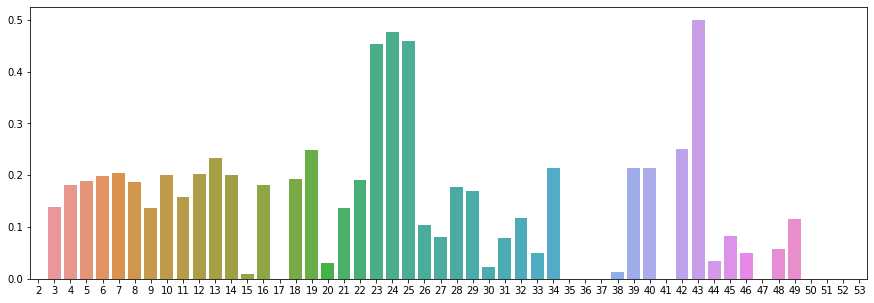

In [707]:
sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

**Is commitsha and commitref identical for all jobs associated with the same buildid?**

In [708]:
(jobs.groupby("buildid").commitsha.nunique() > 1).sum()

0

In [709]:
(jobs.groupby("buildid").commitref.nunique() > 1).sum()

0

Yes, therefore we can add this info to the build df

### Build burst metrics

In [710]:
builds_commitref = jobs.drop_duplicates(subset=["buildid", "commitref", "commitsha"], keep="first")[["buildid", "commitref", "commitsha"]]\
.merge(builds, left_on="buildid", right_on="id")
builds_commitref.head(40)

,buildid,commitref,commitsha,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,241946099,refs/heads/feature/atlas/MMF-324/builtin-profiles,2e4b539138fde6f664a865c81fb6ab0763f74bdb,25614,NaN,241946099,push,2017-06-12 09:21:43+00:00,NaN,2017-06-12 09:21:03+00:00,40.0,canceled,12.0,6.0,2017.0
1,241952022,refs/heads/feature/atlas/MMF-324/builtin-profiles,464f5da96733c14818f4b4bfeb878951b859ee0c,25615,NaN,241952022,push,2017-06-12 09:37:24+00:00,NaN,2017-06-12 09:36:43+00:00,40.0,canceled,12.0,6.0,2017.0
2,241952044,refs/pull/2104/merge,7358e9a93e47ac9fcaebe960c00ab8bd28e9890e,25616,2104.0,241952044,pull_request,2017-06-12 09:53:48+00:00,MMF-324 introduce concept of build-in Quality ...,2017-06-12 09:42:15+00:00,973.0,passed,12.0,6.0,2017.0
3,241955852,refs/heads/feature/jl/onboarding,00e86fd06991a1e54e3b17eb82f2532f85de6489,25617,NaN,241955852,push,2017-06-12 09:56:41+00:00,NaN,2017-06-12 09:50:40+00:00,610.0,failed,12.0,6.0,2017.0
4,241956721,refs/heads/feature/stas/onboarding/tutorial,b34d8845506f0de01138e525d118fe292d204334,25618,NaN,241956721,push,2017-06-12 09:51:07+00:00,NaN,2017-06-12 09:50:27+00:00,64.0,canceled,12.0,6.0,2017.0
5,241956741,refs/pull/2137/merge,0110c87fd42c510bb2c2f7a274d654a9fb07fb29,25619,2137.0,241956741,pull_request,2017-06-12 10:01:41+00:00,UI: SONAR-9355 Create onboarding tutorial,2017-06-12 09:50:05+00:00,1047.0,passed,12.0,6.0,2017.0
6,241963248,refs/heads/feature/jl/onboarding,8823b927339cbb7110f02c42bd12a04ea658897d,25620,NaN,241963248,push,2017-06-12 10:19:03+00:00,NaN,2017-06-12 10:08:56+00:00,885.0,passed,12.0,6.0,2017.0
7,241974640,refs/heads/feature/lambda/onboarding,fc4e2b219f729fd10dba979629ca79eeff0d726c,25621,NaN,241974640,push,2017-06-12 10:52:06+00:00,NaN,2017-06-12 10:51:28+00:00,75.0,canceled,12.0,6.0,2017.0
8,241974654,refs/pull/2133/merge,baf18566bc2af9cab1c72b851ce9e08d3714c731,25622,2133.0,241974654,pull_request,2017-06-12 11:07:10+00:00,MMF-886 Better first-time developer experience,2017-06-12 10:51:36+00:00,1360.0,passed,12.0,6.0,2017.0
9,241975118,refs/pull/2161/merge,939b617446ccc889408ea39ecf00e396443dcedb,25623,2161.0,241975118,pull_request,2017-06-12 11:10:44+00:00,SONAR-9356 Show onboarding tutorial only once ...,2017-06-12 10:54:03+00:00,1463.0,passed,12.0,6.0,2017.0


In [810]:
def detect_build_bursts(_builds, gap_size, burst_size, states):
    positive_count = 0
    negative_count = 0
    n_bursts = 0
    burst_sizes = []
    i = 0
    for index, row in _builds.sort_values(by="started_at").iterrows():
        i+=1
        if((i == len(_builds)) | (not (row.state in states))):
            negative_count+=1
            if(negative_count == gap_size):
                if(positive_count >= burst_size):
                    n_bursts+=1
                    burst_sizes.append(positive_count)
                negative_count = 0
                positive_count = 0
        if(row.state in states):
            positive_count+=1
    return n_bursts, burst_sizes

def build_burst_metrics(row, states):
    _commits = get_commits_from_comparison_row(row, tags_iterative_pr_commits)
    _builds = get_builds_from_commits(_commits)
    _builds = builds_commitref[builds_commitref.id.isin(_builds.id)]
    res = {}
    for gap_size in [1,2,3]:
        for burst_size in [1,2,3]:
            commitref_data=[]
            for commitref in _builds.commitref.unique():
                _ref_builds = _builds[_builds.commitref==commitref]
                commitref_data.append(detect_build_bursts(_ref_builds, gap_size, burst_size, states))
            bursts = np.array([])
            bursts_sizes = np.array([])
            for d in commitref_data:
                bursts = np.append(bursts,d[0])
                for v in d[1]:
                    bursts_sizes = np.append(bursts_sizes,v)
            if not gap_size in res:
                res[gap_size] = {}
            res[gap_size][burst_size] = (bursts, bursts_sizes)
    return res

def get_failed_burst_metrics(row):
    return build_burst_metrics(row, ["failed"])

def get_canceled_burst_metrics(row):
    return build_burst_metrics(row, ["canceled"])

def get_not_passed_burst_metrics(row):
    return build_burst_metrics(row, ["failed", "canceled", "errored"])

In [801]:
def burst_metrics_analysis(burst_metrics, type_str):
    cols = ["index"]
    data = []
    for i, row in burst_metrics.items():
        inner_data = [i]
        for gap in row:
            for burst_size in row[gap]:
                bursts = row[gap][burst_size][0]
                burst_sizes = row[gap][burst_size][1]
                inner_data.append(bursts.mean())
                inner_data.append(np.median(bursts))
                inner_data.append(bursts.max())
                inner_data.append(bursts.min())
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_n_bursts_{metric}")
                inner_data.append(burst_sizes.mean())
                inner_data.append(np.median(burst_sizes))
                inner_data.append(np.max(burst_sizes, initial=0))
                inner_data.append(np.min(burst_sizes, initial=0))
                if(i == 2):
                    for metric in ["mean", "median", "max", "min"]:
                        cols.append(f"{type_str}_gp{gap}_bs{burst_size}_burst_size_{metric}")
        data.append(tuple(inner_data))
    return data, cols

**Not passed burst metrics**

not_passed_burst_metrics = tags_comparison.apply(get_not_passed_burst_metrics,axis=1)

not_passed_burst_metrics.to_csv(f"{csv_folder}/not_passed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(not_passed_burst_metrics, "not_passed")
not_passed_burst_metrics_df = pd.DataFrame(data, columns=cols)
not_passed_burst_metrics_df.set_index("index", inplace=True)
not_passed_burst_metrics_df.shape

not_passed_burst_metrics_df.to_csv(f"{csv_folder}/not_passed_burst_metrics.csv")

In [804]:
not_passed_burst_metrics_df = pd.read_csv(f"{csv_folder}/not_passed_burst_metrics.csv", index_col=0)
not_passed_burst_metrics_df.head(2)

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs2_burst_size_min,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp1_bs3_burst_size_min,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs1_burst_size_min,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs2_burst_size_min,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp2_bs3_burst_size_min,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs1_burst_size_min,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs2_burst_size_min,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,not_passed_gp3_bs3_burst_size_mean,not_passed_gp3_bs3_burst_size_median,not_passed_gp3_bs3_burst_size_max,not_passed_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.512332,0.0,110.0,0.0,2.223195,1.0,88.0,0.0,0.221973,0.0,40.0,0.0,3.823232,2.0,88.0,0.0,0.095291,0.0,18.0,0.0,6.247059,4.0,88.0,0.0,0.362108,0.0,102.0,0.0,2.470588,1.0,89.0,0.0,0.179372,0.0,43.0,0.0,3.96875,2.0,89.0,0.0,0.08296,0.0,21.0,0.0,6.256757,4.0,89.0,0.0,0.279148,0.0,97.0,0.0,2.718876,2.0,89.0,0.0,0.141256,0.0,44.0,0.0,4.396825,3.0,89.0,0.0,0.078475,0.0,23.0,0.0,6.314286,4.0,89.0,0.0


**Canceled burst metrics**

In [811]:
canceled_burst_metrics = tags_comparison.apply(get_canceled_burst_metrics,axis=1)

data, cols = burst_metrics_analysis(canceled_burst_metrics, "canceled")
canceled_burst_metrics_df = pd.DataFrame(data, columns=cols)
canceled_burst_metrics_df.set_index("index", inplace=True)
canceled_burst_metrics_df.head(2)

canceled_burst_metrics_df.to_csv(f"{csv_folder}/canceled_burst_metrics.csv")

In [814]:
canceled_burst_metrics_df = pd.read_csv(f"{csv_folder}/canceled_burst_metrics.csv", index_col=0)
canceled_burst_metrics_df.head(2)

,canceled_gp1_bs1_n_bursts_mean,canceled_gp1_bs1_n_bursts_median,canceled_gp1_bs1_n_bursts_max,canceled_gp1_bs1_n_bursts_min,canceled_gp1_bs1_burst_size_mean,canceled_gp1_bs1_burst_size_median,canceled_gp1_bs1_burst_size_max,canceled_gp1_bs1_burst_size_min,canceled_gp1_bs2_n_bursts_mean,canceled_gp1_bs2_n_bursts_median,canceled_gp1_bs2_n_bursts_max,canceled_gp1_bs2_n_bursts_min,canceled_gp1_bs2_burst_size_mean,canceled_gp1_bs2_burst_size_median,canceled_gp1_bs2_burst_size_max,canceled_gp1_bs2_burst_size_min,canceled_gp1_bs3_n_bursts_mean,canceled_gp1_bs3_n_bursts_median,canceled_gp1_bs3_n_bursts_max,canceled_gp1_bs3_n_bursts_min,canceled_gp1_bs3_burst_size_mean,canceled_gp1_bs3_burst_size_median,canceled_gp1_bs3_burst_size_max,canceled_gp1_bs3_burst_size_min,canceled_gp2_bs1_n_bursts_mean,canceled_gp2_bs1_n_bursts_median,canceled_gp2_bs1_n_bursts_max,canceled_gp2_bs1_n_bursts_min,canceled_gp2_bs1_burst_size_mean,canceled_gp2_bs1_burst_size_median,canceled_gp2_bs1_burst_size_max,canceled_gp2_bs1_burst_size_min,canceled_gp2_bs2_n_bursts_mean,canceled_gp2_bs2_n_bursts_median,canceled_gp2_bs2_n_bursts_max,canceled_gp2_bs2_n_bursts_min,canceled_gp2_bs2_burst_size_mean,canceled_gp2_bs2_burst_size_median,canceled_gp2_bs2_burst_size_max,canceled_gp2_bs2_burst_size_min,canceled_gp2_bs3_n_bursts_mean,canceled_gp2_bs3_n_bursts_median,canceled_gp2_bs3_n_bursts_max,canceled_gp2_bs3_n_bursts_min,canceled_gp2_bs3_burst_size_mean,canceled_gp2_bs3_burst_size_median,canceled_gp2_bs3_burst_size_max,canceled_gp2_bs3_burst_size_min,canceled_gp3_bs1_n_bursts_mean,canceled_gp3_bs1_n_bursts_median,canceled_gp3_bs1_n_bursts_max,canceled_gp3_bs1_n_bursts_min,canceled_gp3_bs1_burst_size_mean,canceled_gp3_bs1_burst_size_median,canceled_gp3_bs1_burst_size_max,canceled_gp3_bs1_burst_size_min,canceled_gp3_bs2_n_bursts_mean,canceled_gp3_bs2_n_bursts_median,canceled_gp3_bs2_n_bursts_max,canceled_gp3_bs2_n_bursts_min,canceled_gp3_bs2_burst_size_mean,canceled_gp3_bs2_burst_size_median,canceled_gp3_bs2_burst_size_max,canceled_gp3_bs2_burst_size_min,canceled_gp3_bs3_n_bursts_mean,canceled_gp3_bs3_n_bursts_median,canceled_gp3_bs3_n_bursts_max,canceled_gp3_bs3_n_bursts_min,canceled_gp3_bs3_burst_size_mean,canceled_gp3_bs3_burst_size_median,canceled_gp3_bs3_burst_size_max,canceled_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.080717,0.0,16.0,0.0,1.513889,1.0,17.0,0.0,0.015695,0.0,5.0,0.0,3.642857,2.0,17.0,0.0,0.004484,0.0,2.0,0.0,7.75,5.5,17.0,0.0,0.063901,0.0,16.0,0.0,1.315789,1.0,8.0,0.0,0.012332,0.0,5.0,0.0,2.636364,2.0,8.0,0.0,0.002242,0.0,2.0,0.0,5.5,5.5,8.0,0.0,0.052691,0.0,15.0,0.0,1.765957,1.0,18.0,0.0,0.013453,0.0,5.0,0.0,4.0,2.0,18.0,0.0,0.003363,0.0,2.0,0.0,10.0,9.0,18.0,0.0


**Failed burst metrics**

failed_burst_metrics = tags_comparison.apply(get_failed_burst_metrics,axis=1)

failed_burst_metrics.to_csv(f"{csv_folder}/failed_burst_metrics_raw.csv")

data, cols = burst_metrics_analysis(failed_burst_metrics, "failed")
failed_burst_metrics_df = pd.DataFrame(data, columns=cols)
failed_burst_metrics_df.set_index("index", inplace=True)
failed_burst_metrics_df.head(2)

failed_burst_metrics_df.to_csv(f"{csv_folder}/failed_burst_metrics.csv")

In [820]:
failed_burst_metrics = pd.read_csv(f"{csv_folder}/failed_burst_metrics.csv", index_col=0)
failed_burst_metrics_df.head(2)

,failed_gp1_bs1_n_bursts_mean,failed_gp1_bs1_n_bursts_median,failed_gp1_bs1_n_bursts_max,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs1_burst_size_min,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs2_burst_size_min,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp1_bs3_burst_size_min,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.00000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,0.418161,0.0,106.0,0.0,2.085791,1.0,88.0,0.0,0.158072,0.0,35.0,0.0,3.87234,2.0,88.0,0.0,0.073991,0.0,17.0,0.0,6.0,4.0,88.0,0.0,0.321749,0.0,94.0,0.0,2.313589,1.0,89.0,0.0,0.13565,0.0,37.0,0.0,4.115702,2.0,89.0,0.0,0.067265,0.0,20.0,0.0,6.266667,4.0,89.0,0.0,0.254484,0.0,90.0,0.0,2.39207,1.0,89.0,0.0,0.105381,0.0,38.0,0.0,4.361702,3.0,89.0,0.0,0.056054,0.0,22.0,0.0,6.44,4.0,89.0,0.0


**Merging metrics**

In [821]:
tags_comparison_x = tags_comparison.merge(failed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x = tags_comparison_x.merge(not_passed_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x = tags_comparison_x.merge(canceled_burst_metrics_df,left_index=True, right_index=True)
tags_comparison_x.shape

(52, 240)

In [736]:
sw_quality_metrics= pd.read_csv(f"{csv_folder}/tags_software_quality_metrics_no_rc_and_milestones.csv", index_col=0)
sw_quality_metrics

,version_name,post_release_bugs,pre_release_bugs,pre_release_after_tagging_bugs,dde,critical_post_release_bugs,minor_post_release_bugs,fix_time
0,4.5.7,1,0.0,0.0,0.000000,0.0,0.0,-434.286030
1,5.1,24,2.0,4.0,0.076923,0.0,2.0,-60.531690
2,5.1.1,6,0.0,0.0,0.000000,0.0,0.0,-18.665239
3,5.1.2,3,0.0,0.0,0.000000,0.0,0.0,-103.197836
4,5.2,48,2.0,9.0,0.040000,0.0,5.0,-110.245705
5,5.3,20,3.0,2.0,0.130435,1.0,2.0,-139.124382
6,5.4,19,11.0,7.0,0.366667,1.0,0.0,-100.247500
7,5.5,9,2.0,3.0,0.181818,0.0,1.0,-11.802482
8,5.6,37,1.0,2.0,0.026316,0.0,2.0,-58.067984
9,5.6.1,9,0.0,0.0,0.000000,0.0,1.0,-92.887575


In [823]:
tags_comparison_x = tags_comparison_x.merge(sw_quality_metrics, left_on="to_tag", right_on="version_name")

In [824]:
from scipy import stats

In [825]:
tags_comparison_x = tags_comparison_x.drop(columns=['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag'])

### Spearman correlation with Number of post release bugs

In [826]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.post_release_bugs)
    if((abs(corr) > 0.5) and (p_val < 0.05)):
        print(col, corr, p_val)

not_passed_gp1_bs2_n_bursts_max 0.5424824615070956 5.6591687941706464e-05
not_passed_gp2_bs2_n_bursts_max 0.5041977392058437 0.00022098454622785158
not_passed_gp3_bs2_n_bursts_max 0.5080954986336369 0.00019377679624048159
canceled_gp1_bs2_n_bursts_max 0.5316868918809188 8.449129756970725e-05
canceled_gp1_bs2_burst_size_max 0.5141881904387305 0.00015729707097420309
canceled_gp1_bs3_n_bursts_mean 0.5111596362592331 0.00017456624685938848
canceled_gp1_bs3_n_bursts_max 0.5390815389429443 6.430252070405836e-05
canceled_gp1_bs3_burst_size_max 0.5327298393966821 8.133052965746757e-05
canceled_gp2_bs3_n_bursts_max 0.5464247707032005 4.871840700043676e-05
canceled_gp2_bs3_burst_size_max 0.5285816793576241 9.457842139896533e-05
canceled_gp3_bs3_n_bursts_mean 0.5042094538192368 0.00022089782369907974
canceled_gp3_bs3_n_bursts_max 0.5520787901871282 3.916954095604031e-05
canceled_gp3_bs3_burst_size_max 0.5312744782647676 8.577183767765248e-05
post_release_bugs 1.0 0.0
pre_release_bugs 0.6116579709

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


### Spearman correlation with Fix Time

In [828]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.fix_time)
    if((abs(corr) > 0.4) and (p_val < 0.05)):
        print(col, corr, p_val)

average_n_job_per_build -0.4915430001342844 0.00033494092345039025
median_n_job_per_commitmessage -0.4848622141741366 0.00041450255048679224
post_release_bugs -0.5592766681231872 2.9500294148456977e-05
fix_time 0.9999999999999999 0.0


In [830]:
for col in tags_comparison_x.columns.values:
    corr, p_val = stats.spearmanr(tags_comparison_x[f"{col}"],tags_comparison_x.dde)
    if((abs(corr) > 0.55) and (p_val < 0.05)):
        print(col, corr, p_val)

failed_gp1_bs2_n_bursts_max 0.5541789254564399 3.6084295342978144e-05
failed_gp2_bs2_n_bursts_mean 0.561679204699427 2.6797336395667515e-05
failed_gp3_bs2_n_bursts_mean 0.583626425447436 1.0748905368832892e-05
failed_gp3_bs2_n_bursts_max 0.5628640025285597 2.5550001001544514e-05
failed_gp3_bs2_burst_size_max 0.5547365735188088 3.530343787122475e-05
failed_gp3_bs3_n_bursts_mean 0.5972229811028662 5.899021783522551e-06
failed_gp3_bs3_n_bursts_max 0.5565088496054604 3.2923636395229025e-05
not_passed_gp2_bs2_n_bursts_mean 0.5594230344521991 2.93287151475096e-05
not_passed_gp2_bs2_n_bursts_max 0.5536894384988407 3.6782745615678575e-05
not_passed_gp3_bs2_n_bursts_max 0.5636658988690203 2.473632553047655e-05
pre_release_bugs 0.9524027843318484 6.845493183076752e-26
pre_release_after_tagging_bugs 0.6066712270000626 3.824354926353909e-06
dde 1.0 0.0


<AxesSubplot:xlabel='not_passed_gp1_bs2_n_bursts_max', ylabel='post_release_bugs'>

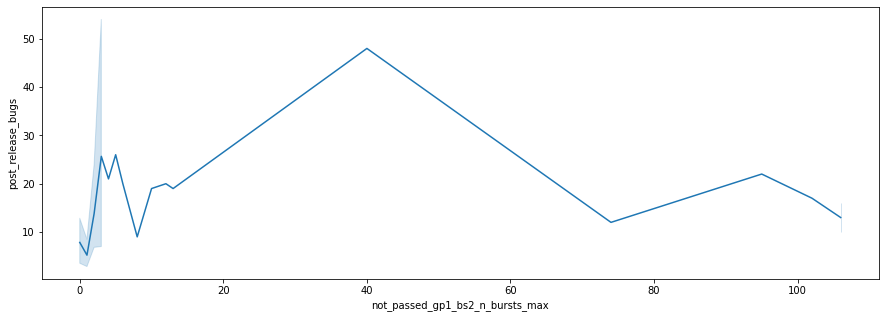

In [792]:
sns.lineplot(x=tags_comparison_x.not_passed_gp1_bs2_n_bursts_max, y=tags_comparison_x.post_release_bugs)